**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_numerical -p 8888:8888 -p 8786:8786 -p 8787:8787 -d palmoreck/jupyterlab_numerical:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_numerical
```


Documentación de la imagen de docker `palmoreck/jupyterlab_numerical:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/numerical).

---

Esta nota utiliza métodos vistos en [1.5.Integracion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.5.Integracion_numerica.ipynb)

**La siguiente celda muestra el modo de utilizar el comando magic de `%pip` para instalar paquetes desde jupyterlab.** Ver [liga](https://ipython.readthedocs.io/en/stable/interactive/magics.html#built-in-magic-commands) para magic commands.

In [ ]:
%%bash
sudo apt-get install -y graphviz

In [3]:
%pip install -q --user graphviz

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


La siguiente celda reiniciará el kernel de **IPython** para cargar los paquetes instalados en la celda anterior. Dar **Ok** en el mensaje que salga y continuar con el contenido del notebook.

In [4]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

{'status': 'ok', 'restart': True}

# Dask

Documentación en: [dask](https://docs.dask.org/en/latest/), [dask-github](https://github.com/dask/dask/), [blog](http://matthewrocklin.com/blog/).

## ¿Qué es y qué nos ofrece?

* Librería para cómputo en paralelo, en específico ayuda al procesamiento en sistemas de memoria compartida o distribuida. Ver [2.2.Sistemas_de_memoria_compartida](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Sistemas_de_memoria_compartida.ipynb).

* Extiende interfaces de arrays, dataframes y listas usadas en `numpy`, `pandas` e `iterators` para el procesamiento en paralelo y manejo de *datasets* que no caben en la memoria RAM: *larger than memory datasets*. En el contexto de dask a los tipos de datos anteriores les denomina **big data collections**. Entonces las *big data collections* soportadas por `dask` son alternativas a los arrays y dataframes de `numpy` y `pandas` para grandes datasets y ejecución en paralelo de **algunas funciones** de éstos paquetes.

* Soporta un task scheduling* dinámico* y optimizado para cómputo*.

\*Task scheduling es un enfoque de paralelización (ver [2.1.Un_poco_de_historia_y_generalidades](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.1.Un_poco_de_historia_y_generalidades.ipynb)) en el que dividimos el programa en muchos *tasks medium-sized*. En `dask` se representan tales tasks como nodos de un grafo con líneas entre éstos si un task depende de lo producido por otro. 

\*Dinámico pues las [task graphs](https://docs.dask.org/en/latest/graphs.html) pueden ser definidas a partir de las *big data collections* o por users.

\*Optimizado para cómputo pues en *dask* existen [task schedulers](https://docs.dask.org/en/latest/scheduling.html) para ejecutar en paralelo (o secuencial) la *task graph*.

* Soporta el enfoque de paralelización de datos (ver [2.1.Un_poco_de_historia_y_generalidades](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.1.Un_poco_de_historia_y_generalidades.ipynb)) con las *collections*: [dask arrays](https://docs.dask.org/en/latest/array.html), [dask dataframes](https://docs.dask.org/en/latest/dataframe.html) y [dask bags](https://docs.dask.org/en/latest/bag.html).

## ¿Cómo se implementan una task y una task graph en dask?

Cada *task* se implementa como un *tuple* de Python que contiene funciones y argumentos de las mismas:

In [1]:
def fun_suma(arg1,arg2):
    return arg1+arg2

t = (fun_suma,-1,2) #tuple, también puede usarse así: t = tuple([fun,-1,2])

In [2]:
t

(<function __main__.fun_suma(arg1, arg2)>, -1, 2)

Una *task graph* se implementa como un diccionario de *tasks*:

In [3]:
diccionario = {'arg1': -1,
               'arg2': 2,
               'resultado': (fun_suma, 'arg1', 'arg2')}

y a este diccionario de tasks se le llama *dask graph*.

**Comentario:** dask posee módulos para optimizar la ejecución de las *task graphs* (ver [optimization](https://docs.dask.org/en/latest/optimize.html))

## ¿Cómo ejecutamos la *dask graph*?

Con los *schedulers* definidos en dask. Ver [Scheduling](https://docs.dask.org/en/latest/scheduling.html) y [Scheduler Overview](https://docs.dask.org/en/latest/scheduler-overview.html)

Para cualquier *scheduler* definido en dask el *entry point* es una función *get* la cual recibe una *dask graph* y una *key* o lista de *keys* para cálculos:

In [4]:
import dask

In [5]:
dask.get(diccionario,'resultado') #synchronous scheduler 

1

In [6]:
dask.threaded.get(diccionario,'resultado') #scheduler backed by a thread pool

1

In [7]:
dask.multiprocessing.get(diccionario,'resultado') #scheduler backed by a process pool

1

**Comentarios:** 

* La función `da.get` ejecuta con un `synchronous scheduler` el cual sólo utiliza un thread de ejecución sin paralelización. Útil para *debugging* y perfilamiento.

* La función `da.threaded.get` ejecuta con un *scheduler* `multiprocessing.pool.ThreadPool`. Como el nombre lo indica, se hacen `fork`'s y `join`'s de un proceso. El overhead para ejecución es pequeño y no hay costo en transferencia de datos entre los *taks*. Sin embargo debido al *GIL* de Python, este scheduler provee paralelización si tu código es esencialmente "no Python", por ejemplo si utilizas código de `numpy` o `pandas` o `cython`. Ver [2.2.Python_multiprocessing](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Python_multiprocessing.ipynb) y [1.7.Compilar_a_C_Cython](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.7.Compilar_a_C_Cython.ipynb).

* La función `da.multiprocessing.get` ejecuta con un *scheduler* `multiprocessing.Pool`. Ver [2.2.Python_multiprocessing](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Python_multiprocessing.ipynb). Se crean para cada *task* un proceso, no tiene problemas del *GIL* de Python para código Python, sin embargo, mover datos hacia procesos y de vuelta al proceso principal tiene costos altos. Útil para *tasks* que no requieren mucha transferencia de datos y cuando los inputs y outputs son pequeños.

**Comentario:** en la documentación de `dask` se recomienda utilizar al *scheduler distributed*, documentación en [Dask.distributed](https://distributed.dask.org/en/latest/), en lugar de usar `da.multiprocesing.get`. Para una pequeña explicación ver [Dask Distributed](https://docs.dask.org/en/latest/scheduling.html#dask-distributed-local).


## ¿Cómo visualizamos la *task graph*?

Usamos `visualize`, ver por ejemplo: [Visualize task graphs](https://docs.dask.org/en/latest/graphviz.html) y [dask.visualize](https://docs.dask.org/en/latest/api.html#dask.visualize).

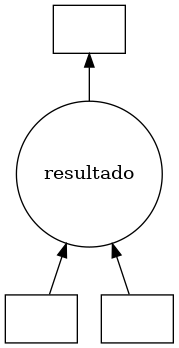

In [8]:
dask.visualize(diccionario,'resultado')

Las cajas representan datos, los círculos representan funciones que se ejecutan sobre tales datos y las flechas especifican cuáles funciones producen/consumen qué datos.

## En resumen en dask seguimos un flujo como el siguiente dibujo:

<img src="https://docs.dask.org/en/latest/_images/dask-overview.svg" heigth="400" width="400">

**y para crear task graphs podemos partir de las *collections* o definir nuestras propias *dask graphs*.**

**Comentario**: si trabajamos con las *collections* será extraño que trabajemos a nivel de funciones `get`. Cada *collection* tiene un default scheduler y una función [compute](https://docs.dask.org/en/latest/scheduler-overview.html#using-compute-methods) que calcula el output de la *collection*:

**Ejemplo:**

[dask arrays](https://docs.dask.org/en/latest/array.html) y [dask dataframes](https://docs.dask.org/en/latest/dataframe.html) utilizan al *threaded scheduler* por default pero con `compute` puede cambiarse de *scheduler*:

In [9]:
import dask.array as da

In [10]:
x = da.arange(100)

In [11]:
x

dask.array<arange, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [12]:
type(x)

dask.array.core.Array

Utilizando el *threaded scheduler* para el *dask array*:

In [13]:
x.sum().compute()

4950

Modificando el *scheduler* con *compute*:

In [14]:
x.sum().compute(scheduler='processes')

4950

**Comentario:** por default `dask` trabaja con *chunks*. En el ejemplo pasado no definimos, pero podemos hacer:

In [15]:
x = da.arange(100, chunks=10)

In [16]:
x

dask.array<arange, shape=(100,), dtype=int64, chunksize=(10,), chunktype=numpy.ndarray>

**Comentario:** también por *default*, `dask` trabaja de una forma *lazy*, esto es, `dask` no calculará ningún resultado hasta que explícitamente se le dé la instrucción. Por ejemplo, podemos hacer:

In [17]:
y = x.sum()

In [18]:
y

dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

y hasta ahora no se ha calculado la suma (cuyo resultado es un escalar). Después de llamar a `compute` se ejecuta la *task graph* para ejecución en paralelo (si se definió al *scheduler* para este tipo de ejecución):

In [20]:
y.compute()

4950

# Regla del rectángulo

In [ ]:
import math
import time
from scipy.integrate import quad

https://docs.dask.org/en/latest/scheduler-overview.html

distributed.Client.get: a distributed scheduler for executing graphs
    on multiple machines. This lives in the external distributed project.



**Referencias:**

1. [2.1.Un_poco_de_historia_y_generalidades](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.1.Un_poco_de_historia_y_generalidades.ipynb)

2. [2.2.Python_multiprocessing](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Python_multiprocessing.ipynb)

3. [dask](https://docs.dask.org/en/latest/)


Otras referencias:

* [Use cases with dask](https://stories.dask.org/en/latest/)

* [dask-tutorial](https://github.com/dask/dask-tutorial)